#### NHTS Data Analysis

This notebook is for analysing the NHTS 2017 data:
- Filtering for trips that start and end in Phoenix, AZ
- Calculating mode and purpose share percentages
- Calculating median trip distances for driving trips under each purpose

In [1]:
# import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# note about dataset 'tripctbg.csv': this is not a publicly-available dataset (NHTS census block group-level data)
# please contact FHWA NHTS program for access to the census block group-level data

In [2]:
# read in data
trips_bg = pd.read_csv('tripctbg.csv')
trips = pd.read_csv('trippub.csv')

In [3]:
# preview trips_bg
trips_bg.head()

,HOUSEID,PERSONID,TDTRPNUM,ORIG_COUNTRY,ORIG_ST,ORIG_CNTY,ORIG_CT,ORIG_BG,DEST_COUNTRY,DEST_ST,DEST_CNTY,DEST_CT,DEST_BG
0,30000007,1,1,USA,37,191,001301,1,USA,37,191,001200,2
1,30000007,1,2,USA,37,191,001200,2,USA,37,191,001301,1
2,30000007,2,1,USA,37,183,053717,1,USA,37,191,001301,1
3,30000007,2,2,USA,37,191,001301,1,USA,37,183,053717,1
4,30000007,3,1,USA,37,191,001301,1,USA,37,191,001302,2


In [4]:
# merge data on house ID, person ID, and travel day trip number
trips = trips.merge(trips_bg, on=['HOUSEID', 'PERSONID', 'TDTRPNUM'])

In [ ]:
# preview merged data
trips.head(10)

,HOUSEID,PERSONID,TDTRPNUM,STRTTIME,ENDTIME,TRVLCMIN,TRPMILES,TRPTRANS,TRPACCMP,TRPHHACC,...,ORIG_COUNTRY,ORIG_ST,ORIG_CNTY,ORIG_CT,ORIG_BG,DEST_COUNTRY,DEST_ST,DEST_CNTY,DEST_CT,DEST_BG
0,30000007,1,1,1000,1015,15,5.244,3,0,0,...,USA,37,191,001301,1,USA,37,191,001200,2
1,30000007,1,2,1510,1530,20,5.149,3,0,0,...,USA,37,191,001200,2,USA,37,191,001301,1
2,30000007,2,1,700,900,120,84.004,6,0,0,...,USA,37,183,053717,1,USA,37,191,001301,1
3,30000007,2,2,1800,2030,150,81.628,6,0,0,...,USA,37,191,001301,1,USA,37,183,053717,1
4,30000007,3,1,845,900,15,2.250,3,0,0,...,USA,37,191,001301,1,USA,37,191,001302,2
5,30000007,3,2,1430,1445,15,2.243,3,0,0,...,USA,37,191,001302,2,USA,37,191,001301,1
6,30000008,1,1,1115,1130,15,8.017,6,0,0,...,USA,55,109,120202,2,USA,55,109,120903,1
7,30000008,1,2,2330,2340,10,8.017,6,0,0,...,USA,55,109,120903,1,USA,55,109,120202,2
8,30000012,1,1,550,605,15,3.395,4,0,0,...,USA,36,001,001500,4,USA,36,001,014100,3
9,30000012,1,2,700,715,15,3.395,4,0,0,...,USA,36,001,014100,3,USA,36,001,001500,4


In [6]:
# create dictionaries to map modes and purpose codes from NHTS 2017 codebook to categories used in this study
# refer to codebook_v1.2_annotated.xlsx, trips sheet for more information

modes = {1: 'NMT', 2: 'NMT', 3: 'Drive', 4: 'Drive', 5: 'Drive', 
         6: 'Drive', 7: 'Other', 8: 'Drive', 9: 'Drive', 10: 'Transit', 
         11: 'Transit', 12: 'Transit', 13: 'Drive', 14: 'Transit', 15: 'Transit', 
         16: 'Transit', 17 : 'Drive', 18: 'Drive', 19: 'Other', 20: 'Other', 
         97: 'Other'}

purposes = {1: 'Home', 2: 'Work/School', 3: 'Work/School', 4: 'Work/School', 
            5: 'Social/Recreational', 6: 'Errand/Escort', 7: 'Other', 8: 'Work/School', 
            9: 'Errand/Escort', 10: 'Errand/Escort', 11: 'Commercial', 12: 'Commercial', 
            13: 'Commercial', 14: 'Errand/Escort', 15: 'Social/Recreational', 16: 'Social/Recreational', 
            17: 'Social/Recreational', 18: 'Errand/Escort', 19: 'Social/Recreational', 97: 'Other'}

trips['overall_mode'] = trips['TRPTRANS'].map(modes)
trips['overall_purpose'] = trips['WHYTO'].map(purposes)

In [7]:
# read in list of City of Phoenix census tracts
phx_tracts = pd.read_csv('phx_census_tracts.csv')

# change census tract int64 type to str type to match ORIG_CT and DEST_CT datatype in NHTS data
phx_tracts['TRACTID'] = phx_tracts['TRACTID'].astype(str)

# insert leading zeros to match ORIG_CT and DEST_CT format in NHTS data
phx_tracts['TRACTID'] = phx_tracts['TRACTID'].str.zfill(6)

In [8]:
# filter data to only include trips that start and end within the City of Phoenix
trips_phx = trips[(trips['ORIG_ST'] == '04') & (trips['DEST_ST'] == '04') &
                  (trips['ORIG_CNTY'] == '013') & (trips['DEST_CNTY'] == '013') &
                  (trips['ORIG_CT'].isin(phx_tracts['TRACTID'])) & (trips['DEST_CT'].isin(phx_tracts['TRACTID']))]
trips_phx

,HOUSEID,PERSONID,TDTRPNUM,STRTTIME,ENDTIME,TRVLCMIN,TRPMILES,TRPTRANS,TRPACCMP,TRPHHACC,...,ORIG_CNTY,ORIG_CT,ORIG_BG,DEST_COUNTRY,DEST_ST,DEST_CNTY,DEST_CT,DEST_BG,overall_mode,overall_purpose
7372,30008488,2,1,1230,1300,30,27.697,6,0,0,...,013,113802,1,USA,04,013,612200,1,Drive,Home
10004,30011415,1,2,1730,1750,20,6.916,4,0,0,...,013,614700,1,USA,04,013,614200,2,Drive,Commercial
10008,30011415,2,2,1745,1800,15,5.984,3,0,0,...,013,614700,1,USA,04,013,614200,3,Drive,Commercial
13189,30015000,2,2,1830,1915,45,16.065,4,0,0,...,013,112900,3,USA,04,013,103215,2,Drive,Social/Recreational
24808,30028130,2,1,830,900,30,5.858,6,0,0,...,013,082203,1,USA,04,013,112509,2,Drive,Work/School
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
920098,40787879,3,2,1420,1430,10,0.217,1,0,0,...,013,110600,4,USA,04,013,110600,4,NMT,Home
921750,40790828,1,1,1545,1552,7,6.539,3,0,0,...,013,617000,3,USA,04,013,613300,4,Drive,Social/Recreational
921751,40790828,1,2,1810,1817,7,6.778,3,0,0,...,013,613300,4,USA,04,013,617000,3,Drive,Home
922961,40793144,1,7,1410,1415,5,0.175,6,1,1,...,013,618000,3,USA,04,013,618000,3,Drive,Commercial


#### Define Mode and Purpose Categories
Use the NHTS 2017 codebook to help define the modes and purpose categories.

The modes considered are:
- Drive
- Transit
- NMT

The purposes considered are:
- Home
- Work/School
- Commercial
- Social/Recreational
- Errand/Escort

In [ ]:
# # create dictionaries to map modes and purpose codes from NHTS 2017 codebook to categories used in this study
# # refer to codebook_v1.2_annotated.xlsx, trips sheet for more information

modes = {1: 'NMT', 2: 'NMT', 3: 'Drive', 4: 'Drive', 5: 'Drive', 
         6: 'Drive', 7: 'Other', 8: 'Drive', 9: 'Drive', 10: 'Transit', 
         11: 'Transit', 12: 'Transit', 13: 'Drive', 14: 'Transit', 15: 'Transit', 
         16: 'Transit', 17 : 'Drive', 18: 'Drive', 19: 'Other', 20: 'Other', 
         97: 'Other'}

purposes = {1: 'Home', 2: 'Work/School', 3: 'Work/School', 4: 'Work/School', 
            5: 'Social/Recreational', 6: 'Errand/Escort', 7: 'Other', 8: 'Work/School', 
            9: 'Errand/Escort', 10: 'Errand/Escort', 11: 'Commercial', 12: 'Commercial', 
            13: 'Commercial', 14: 'Errand/Escort', 15: 'Social/Recreational', 16: 'Social/Recreational', 
            17: 'Social/Recreational', 18: 'Errand/Escort', 19: 'Social/Recreational', 97: 'Other'}

trips_phx['overall_mode'] = trips_phx['TRPTRANS'].map(modes)
trips_phx['overall_purpose'] = trips_phx['WHYTO'].map(purposes)

In [10]:
# drop rows with modes and purposes that are negative
# (-9: not ascertained, -8: I don't know, -7: prefer not to answer)
excluded_codes = [-9, -8, -7]
trips_phx = trips_phx[~(trips_phx['TRPTRANS'].isin(excluded_codes)) & ~(trips_phx['overall_purpose'].isin(excluded_codes))]

In [11]:
# calculate total number of weighted trips in City of Phoenix
total_trips = trips_phx['WTTRDFIN'].sum()
total_trips
# need to find out what time period this trip count is over [later found this out - weighting is for annual trips]

1416984862.693542

In [12]:
# overall mode split
mode_split = trips_phx[['overall_mode', 'WTTRDFIN']].groupby('overall_mode').sum()
# normalize
mode_split['overall_mode'] = mode_split['WTTRDFIN'] / mode_split['WTTRDFIN'].sum()
mode_split

,WTTRDFIN,overall_mode
overall_mode,,
Drive,1.206586e+09,0.851517
NMT,1.622685e+08,0.114517
Other,2.190188e+06,0.001546
Transit,4.594020e+07,0.032421


In [13]:
# overall purpose split
purpose_split = trips_phx[['overall_purpose', 'WTTRDFIN']].groupby('overall_purpose').sum()
# normalize
purpose_split['overall_purpose'] = purpose_split['WTTRDFIN'] / purpose_split['WTTRDFIN'].sum()
purpose_split

,WTTRDFIN,overall_purpose
overall_purpose,,
Commercial,3.368490e+08,0.237917
Errand/Escort,1.483867e+08,0.104806
Home,4.962710e+08,0.350517
Other,8.859951e+06,0.006258
Social/Recreational,2.256028e+08,0.159343
Work/School,1.998582e+08,0.141160


In [67]:
# mode-purpose split
mode_purpose_split = trips_phx[['overall_mode', 'overall_purpose', 'WTTRDFIN']].groupby(['overall_mode', 'overall_purpose']).sum()
# normalize
mode_purpose_split['mode_purpose_split'] = np.round(mode_purpose_split['WTTRDFIN'] / mode_purpose_split['WTTRDFIN'].sum()*100, 2)
mode_purpose_split

WTTRDFIN  mode_purpose_split
overall_mode overall_purpose                                      
Drive        Commercial           3.084599e+08               21.79
             Errand/Escort        1.411627e+08                9.97
             Home                 4.075136e+08               28.78
             Other                5.439672e+06                0.38
             Social/Recreational  1.764007e+08               12.46
             Work/School          1.664522e+08               11.76
NMT          Commercial           2.388016e+07                1.69
             Errand/Escort        4.455284e+06                0.31
             Home                 6.965709e+07                4.92
             Other                2.694582e+06                0.19
             Social/Recreational  4.326326e+07                3.06
             Work/School          1.831808e+07                1.29
Other        Home                 2.149292e+06                0.15
             Work/School          4.089639e+04                0.00
Transit      Commercial           4.508909e+06                0.32
             Errand/Escort        2.768668e+06                0.20
             Home                 1.695109e+07                1.20
             Other                7.256973e+05                0.05
             Social/Recreational  5.938838e+06                0.42
             Work/School          1.504700e+07                1.06

In [15]:
# show mode_purpose_split for all overall_modes except other
mode_purpose_split = mode_purpose_split.reset_index()
mode_purpose_split = mode_purpose_split[(mode_purpose_split['overall_mode'] != 'Other') & (mode_purpose_split['overall_purpose'] != 'Other')]
mode_purpose_split

,overall_mode,overall_purpose,WTTRDFIN,mode_purpose_split
0,Drive,Commercial,3.084599e+08,21.79
1,Drive,Errand/Escort,1.411627e+08,9.97
2,Drive,Home,4.075136e+08,28.78
4,Drive,Social/Recreational,1.764007e+08,12.46
5,Drive,Work/School,1.664522e+08,11.76
6,NMT,Commercial,2.388016e+07,1.69
7,NMT,Errand/Escort,4.455284e+06,0.31
8,NMT,Home,6.965709e+07,4.92
10,NMT,Social/Recreational,4.326326e+07,3.06
11,NMT,Work/School,1.831808e+07,1.29


#### Calculate average and median VMT of each mode-purpose split

In [16]:
# iterate across all modes and purposes to calculate average and median trip_path_distance
dist_trips = []
for mode in ['Drive', 'Transit', 'NMT']:
    for purpose in ['Home', 'Work/School', 'Commercial', 'Social/Recreational', 'Errand/Escort']:
        dist = trips_phx[(trips_phx['overall_mode'] == mode) & (trips_phx['overall_purpose'] == purpose)]
        dist_avg = dist['TRPMILES'].mean()
        dist_med = dist['TRPMILES'].median()
        dist_trips.append([mode, purpose, dist_avg, dist_med])
        
        print(f'{mode} {purpose} avg: {dist_avg} med: {dist_med}')

Drive Home avg: 5.785259052924791 med: 3.191
Drive Work/School avg: 8.108216560509552 med: 5.755
Drive Commercial avg: 3.9695961538461537 med: 2.2805
Drive Social/Recreational avg: 5.6715174825174826 med: 3.639
Drive Errand/Escort avg: 6.636395683453238 med: 4.194
Transit Home avg: 8.545545454545454 med: 6.436
Transit Work/School avg: 7.637111111111112 med: 5.261
Transit Commercial avg: 2.7805 med: 2.418
Transit Social/Recreational avg: 3.3063333333333333 med: 3.477
Transit Errand/Escort avg: 12.832 med: 12.832
NMT Home avg: 1.1294126984126984 med: 0.541
NMT Work/School avg: 0.7726363636363637 med: 0.49250000000000005
NMT Commercial avg: 0.701111111111111 med: 0.548
NMT Social/Recreational avg: 0.7360882352941178 med: 0.4315
NMT Errand/Escort avg: 0.179 med: 0.1475


In [17]:
dist_trips = pd.DataFrame(dist_trips, columns=['mode', 'purpose', 'avg_dist', 'med_dist'])

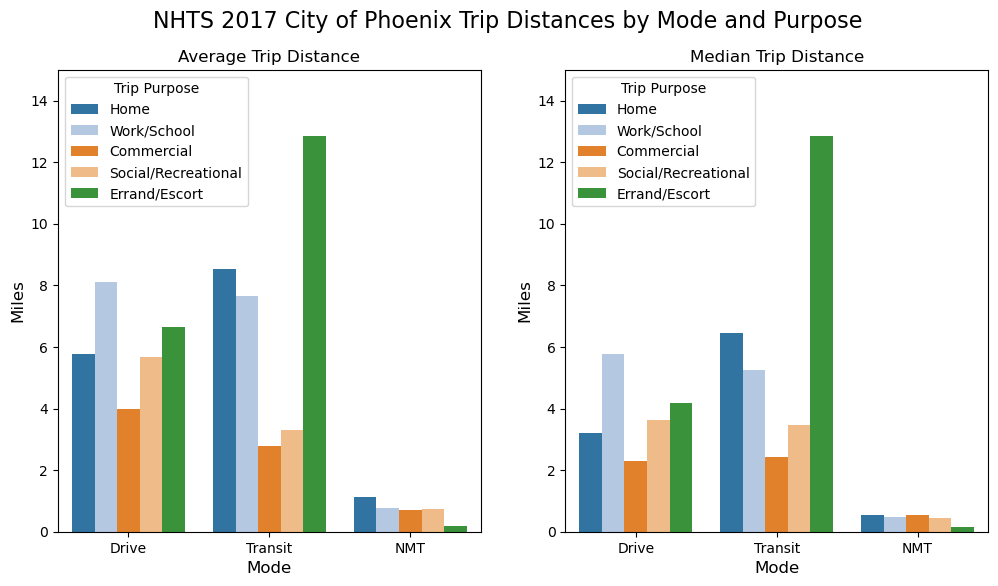

In [18]:
# plot average and median trip distances from dist_trips
# set color scheme
sns.set_palette("tab20")

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.barplot(data=dist_trips, x='mode', y='avg_dist', hue='purpose', ax=ax[0])
sns.barplot(data=dist_trips, x='mode', y='med_dist', hue='purpose', ax=ax[1])

# set both subplots to have same y-limits
for a in ax:
    a.set_ylim(0, 15)

ax.flat[0].set_title('Average Trip Distance')
ax.flat[1].set_title('Median Trip Distance')

# set y-labels
ax.flat[0].set_ylabel('Miles', size=12)
ax.flat[1].set_ylabel('Miles', size=12)
ax.flat[0].set_xlabel('Mode', size=12)
ax.flat[1].set_xlabel('Mode', size=12)

# set legend title
ax.flat[0].legend(title='Trip Purpose')
ax.flat[1].legend(title='Trip Purpose')

# set plot title
fig.suptitle('NHTS 2017 City of Phoenix Trip Distances by Mode and Purpose', size=16)

plt.show()


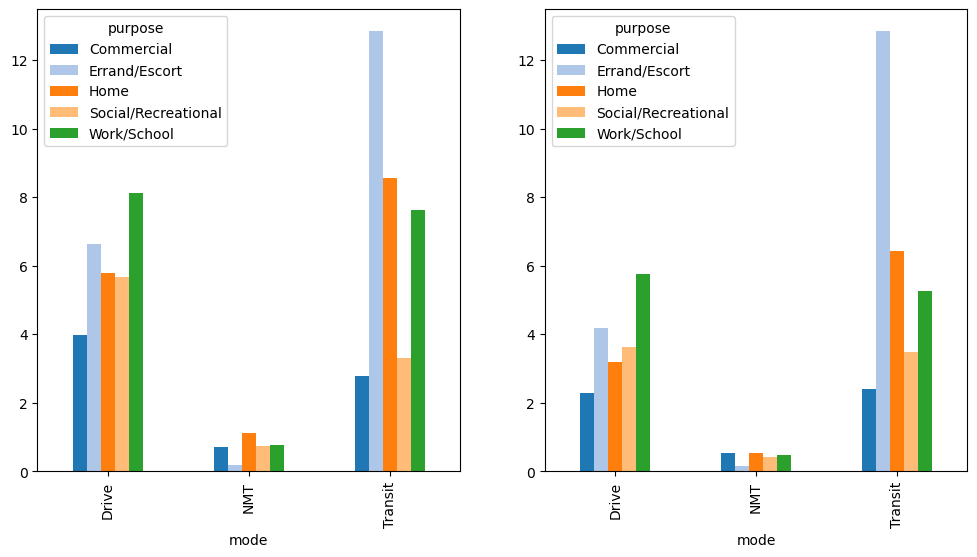

In [19]:
# create grouped bar plot of dist_trips, grouped by average or median
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
dist_trips.pivot(index='mode', columns='purpose', values='avg_dist').plot(kind='bar', ax=ax[0])
dist_trips.pivot(index='mode', columns='purpose', values='med_dist').plot(kind='bar', ax=ax[1])
plt.show()

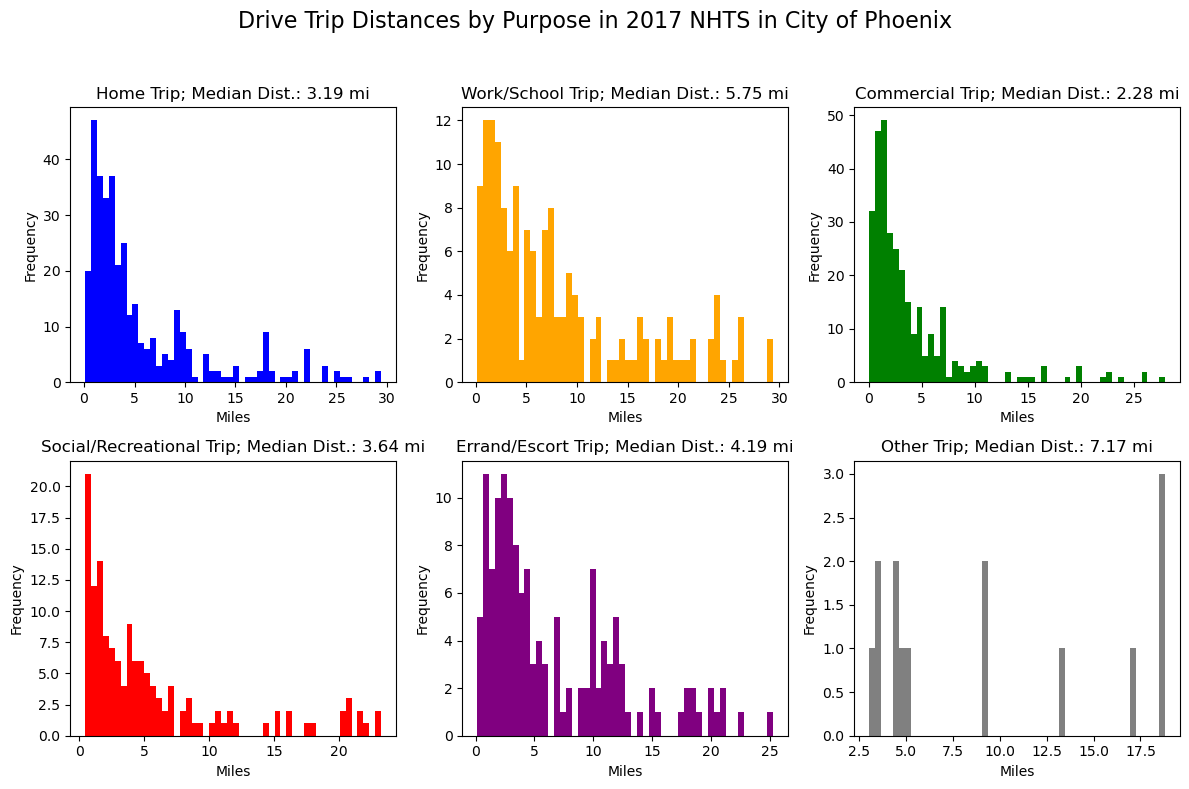

In [20]:
# set parameters for histograms
num_bins = 50
max_dist = 30

# Define a list of colors for each plot
colors = ['blue', 'orange', 'green', 'red', 'purple', 'grey']

# Create tiled histograms
fig, ax = plt.subplots(2, 3, figsize=(12, 8))
fig.suptitle('Drive Trip Distances by Purpose in 2017 NHTS in City of Phoenix', size=16)

for i, purpose in enumerate(['Home', 'Work/School', 'Commercial', 'Social/Recreational', 'Errand/Escort', 'Other']):
    # Filter data for the current purpose and 'Drive' mode
    drive_purpose = trips_phx[(trips_phx['overall_mode'] == 'Drive') & (trips_phx['overall_purpose'] == purpose)]
    
    # Plot histogram with a specific color from the colors list
    ax.flat[i].hist(
        drive_purpose[drive_purpose['TRPMILES'] < max_dist]['TRPMILES'], 
        bins=num_bins, 
        color=colors[i]
    )
    
    # Set titles and labels
    ax.flat[i].set_title(f'{purpose} Trip; Median Dist.: {drive_purpose["TRPMILES"].median():.2f} mi')
    ax.flat[i].set_xlabel('Miles')
    ax.flat[i].set_ylabel('Frequency')

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit title
plt.show()

##### Calculate mean number of travellers per drive trip

In [21]:
# calculate average number of additional travellers on each drive trip (use trip weights)
travel_mode = "Drive"
weighted_avg_pax_per_drive_trip = np.sum(trips_phx[trips_phx["overall_mode"] == travel_mode]["TRPACCMP"] * trips_phx[trips_phx["overall_mode"] == travel_mode]["WTTRDFIN"]) / trips_phx[trips_phx["overall_mode"] == travel_mode]["WTTRDFIN"].sum()
weighted_avg_pax_per_drive_trip

1.0960407770772296

Text(0, 0.5, 'Weighted Frequency')

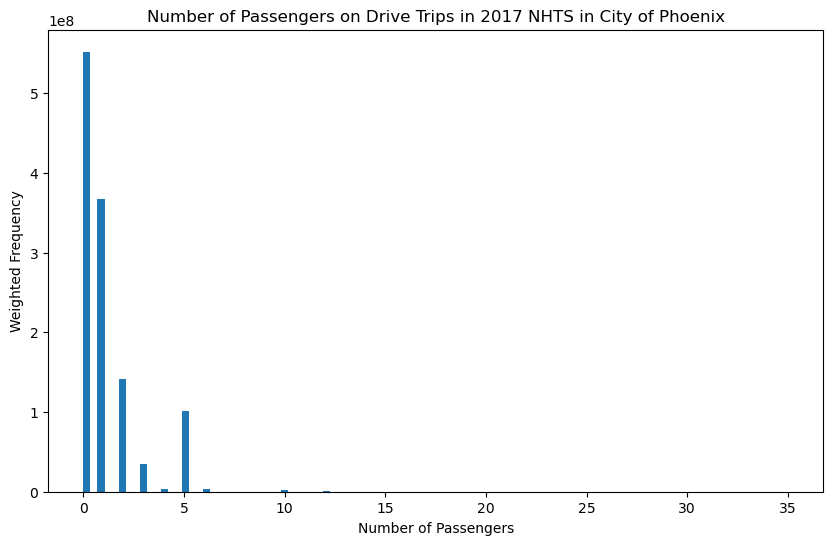

In [22]:
# plot histogram of number of passengers on drive trips
plt.figure(figsize=(10, 6))
plt.hist(trips_phx[trips_phx["overall_mode"] == "Drive"]["TRPACCMP"], bins=100, weights=trips_phx[trips_phx["overall_mode"] == "Drive"]["WTTRDFIN"])
plt.title("Number of Passengers on Drive Trips in 2017 NHTS in City of Phoenix")
plt.xlabel("Number of Passengers")
plt.ylabel("Weighted Frequency")

#### Investigate source of high number of passengers per drive trip
Three ideas to look into the high number of people in the vehicle for each drive trip of 2.124:
1. Calculate breakdown of additional passengers by trip purpose
2. Compare household size between Phoenix (NHTS 2017) and Seattle (PSRC HTS 2019)
3. Compare number of additional passengers (TRPACCMP) from Phoenix with figures from NHTS for Seattle and federally

In [23]:
# calculate mean number of passengers on drive trips, sorted by trip purpose
pax_per_drive_trip = trips_phx[trips_phx["overall_mode"] == "Drive"].groupby("overall_purpose").apply(lambda x: np.sum(x["TRPACCMP"] * x["WTTRDFIN"]) / x["WTTRDFIN"].sum())
pax_per_drive_trip

overall_purpose
Commercial             1.339843
Errand/Escort          1.186587
Home                   0.857652
Other                  0.282908
Social/Recreational    1.737429
Work/School            0.498601
dtype: float64

In [24]:
# read in household data
hh = pd.read_csv('hhpub.csv')

In [25]:
# merge hh and trips data on HOUSEID
hh_trips = hh.merge(trips_phx, on='HOUSEID') 

In [26]:
# read in PSRC HTS household and trip data
hh_psrc = pd.read_csv('Household_Travel_Survey_Households.csv')
trips_psrc = pd.read_csv('Household_Travel_Survey_Trips.csv')

C:\Users\jerem\AppData\Local\Temp\ipykernel_16820\3345884634.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  hh_psrc = pd.read_csv('Household_Travel_Survey_Households.csv')
C:\Users\jerem\AppData\Local\Temp\ipykernel_16820\3345884634.py:3: DtypeWarning: Columns (5,8,25,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,52,68,69,73,75,76,79,86,87,88,89,90,91,92,93,94,95,96,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,130,131,132,133,134,135,136,137,138,139,140,142,154) have mixed types. Specify dtype option on import or set low_memory=False.
  trips_psrc = pd.read_csv('Household_Travel_Survey_Trips.csv')


In [27]:
# merge psrc hh and trips data, and filter trips to only include trips in City of Seattle
trips_hh_psrc = trips_psrc.merge(hh_psrc, on='household_id')
trips_hh_seattle = trips_hh_psrc[trips_hh_psrc['survey_year_x'] == 2019]
trips_hh_seattle = trips_hh_seattle[(trips_hh_seattle['travelers_total'] > 0) & (trips_hh_seattle['travelers_total'] < 100)]

# filter Seattle PUMA10 codes
seattle_puma10 = [11601, 11602, 11603, 11604, 11605]
trips_hh_seattle = trips_hh_seattle[(trips_hh_seattle['o_puma10'].isin(seattle_puma10) & trips_hh_seattle['d_puma10'].isin(seattle_puma10))]
trips_hh_seattle = trips_hh_seattle[trips_hh_seattle['trip_path_distance'] <= 50]

In [28]:
# drop the word 'person' or 'people' from hhsize_x
trips_hh_seattle['hhsize_y'] = trips_hh_seattle['hhsize_y'].str.replace(' person', '')
trips_hh_seattle['hhsize_y'] = trips_hh_seattle['hhsize_y'].str.replace(' people', '')

# convert hhsize_x to int
trips_hh_seattle['hhsize_y'] = trips_hh_seattle['hhsize_y'].astype(int)

In [29]:
# only extract rows with unique hhid for Seattle
trips_hh_seattle = trips_hh_seattle.drop_duplicates(subset='household_id')
trips_hh_seattle['hhsize_y'].value_counts()

hhsize_y
1    909
2    761
3    179
4     99
5     15
6      4
8      2
Name: count, dtype: int64

In [30]:
# only extract rows with unique HOUSEID for Phoenix
hh_trips = hh_trips.drop_duplicates(subset='HOUSEID')
hh_trips['HHSIZE_x'].value_counts()

HHSIZE_x
2    109
1     92
3     40
4     34
5      8
7      2
6      1
Name: count, dtype: int64

In [31]:
# calculate average household size for Seattle, weighted by hh_weight
weighted_avg_hh_size_seattle = np.sum(trips_hh_seattle['hhsize_y'] * trips_hh_seattle['hh_weight']) / trips_hh_seattle['hh_weight'].sum()
weighted_avg_hh_size_seattle

2.3253225089947307

In [32]:
# calculate average household size for Phoenix, weighted by WTHHFIN
weighted_avg_hh_size_phoenix = np.sum(hh_trips['HHSIZE_x'] * hh_trips['WTHHFIN']) / hh_trips['WTHHFIN'].sum()
weighted_avg_hh_size_phoenix

2.443555637349041

In [33]:
# calculate percentage of total households of each household size in Seattle
hh_size_split_seattle = trips_hh_seattle[['hhsize_y', 'hh_weight']].groupby('hhsize_y').sum()
hh_size_split_seattle['hh_size_split'] = hh_size_split_seattle['hh_weight'] / hh_size_split_seattle['hh_weight'].sum() * 100
hh_size_split_seattle

,hh_weight,hh_size_split
hhsize_y,,
1,165142.041358,31.668177
2,185243.762861,35.522949
3,67248.096441,12.895715
4,69448.309783,13.317635
5,24052.356145,4.612358
6,2781.111052,0.533315
8,7560.632377,1.449852


In [34]:
# insert new row in hh_size_split_seattle to represent no households with 7 people
hh_size_split_seattle.loc[7] = [0, 0]
hh_size_split_seattle = hh_size_split_seattle.sort_index()
hh_size_split_seattle

,hh_weight,hh_size_split
hhsize_y,,
1,165142.041358,31.668177
2,185243.762861,35.522949
3,67248.096441,12.895715
4,69448.309783,13.317635
5,24052.356145,4.612358
6,2781.111052,0.533315
7,0.000000,0.000000
8,7560.632377,1.449852


In [35]:
# calculate percentage of total households of each household size in Phoenix
hh_size_split_phx = hh_trips[['HHSIZE_x', 'WTHHFIN']].groupby('HHSIZE_x').sum()
hh_size_split_phx['hh_size_split'] = hh_size_split_phx['WTHHFIN'] / hh_size_split_phx['WTHHFIN'].sum() * 100
hh_size_split_phx

,WTHHFIN,hh_size_split
HHSIZE_x,,
1,180845.389364,29.632066
2,178819.567827,29.300129
3,106367.736039,17.428677
4,102826.978022,16.848513
5,30828.608837,5.051361
6,6032.390065,0.988425
7,4582.329280,0.750829


([<matplotlib.axis.XTick at 0x21009ab3190>,
 [Text(0, 0, '1'),
  Text(1, 0, '2'),
  Text(2, 0, '3'),
  Text(3, 0, '4'),
  Text(4, 0, '5'),
  Text(5, 0, '6'),
  Text(6, 0, '7'),
  Text(7, 0, '8')])

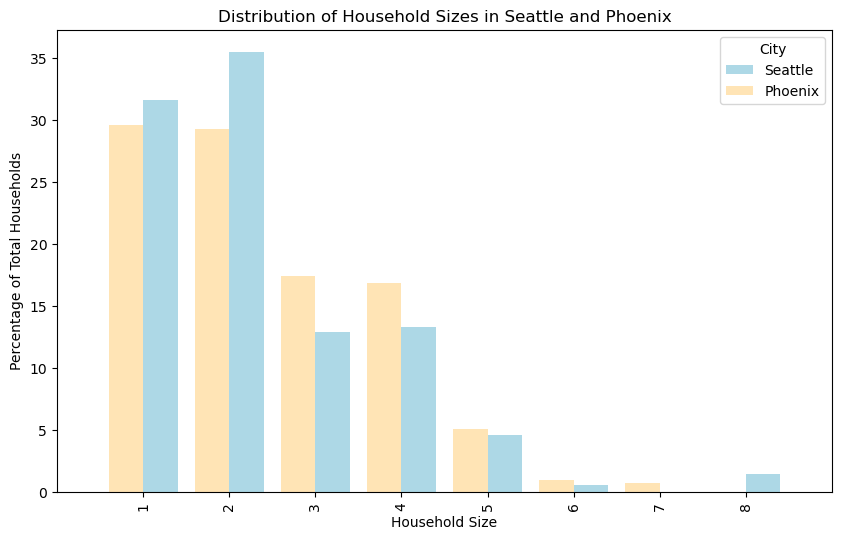

In [36]:
# plot distribution of household sizes in Seattle and Phoenix as a side-by-side bar plot
fig, ax = plt.subplots(figsize=(10, 6))
hh_size_split_seattle['hh_size_split'].plot(kind='bar', color='lightblue', width=0.4, position=0, ax=ax, label='Seattle')
hh_size_split_phx['hh_size_split'].plot(kind='bar', color='moccasin', width=0.4, position=1, ax=ax, label='Phoenix')

# set plot title and labels
plt.title('Distribution of Household Sizes in Seattle and Phoenix')
plt.xlabel('Household Size')
plt.ylabel('Percentage of Total Households')
plt.legend(title='City')
plt.xlim(-1, 8)

# set x ticks to be integers from 1 to 8
plt.xticks(range(8), range(1, 9))



In [37]:
# calculate mean household size of Phoenix trips, weighted by HH weights
mean_hh_size = np.sum(hh_trips["HHSIZE_x"] * hh_trips["WTHHFIN"]) / hh_trips["WTHHFIN"].sum()
mean_hh_size

2.443555637349041

In [60]:
# filter out NHTS trips to only include trips in the City of Seattle
sea_tracts = pd.read_csv('sea_census_tracts.csv')

# change census tract int64 type to str type to match ORIG_CT and DEST_CT datatype in NHTS data
sea_tracts['TRACTID'] = sea_tracts['TRACTID'].astype(str)

# insert leading zeros to match ORIG_CT and DEST_CT format in NHTS data
sea_tracts['TRACTID'] = sea_tracts['TRACTID'].str.zfill(6)

In [61]:
# filter data to only include trips that start and end within the City of Seattle
trips_sea = trips[(trips['ORIG_ST'] == '53') & (trips['DEST_ST'] == '53') &
                  (trips['ORIG_CNTY'] == '033') & (trips['DEST_CNTY'] == '033') &
                  (trips['ORIG_CT'].isin(sea_tracts['TRACTID'])) & (trips['DEST_CT'].isin(sea_tracts['TRACTID']))]
trips_sea

,HOUSEID,PERSONID,TDTRPNUM,STRTTIME,ENDTIME,TRVLCMIN,TRPMILES,TRPTRANS,TRPACCMP,TRPHHACC,...,ORIG_CNTY,ORIG_CT,ORIG_BG,DEST_COUNTRY,DEST_ST,DEST_CNTY,DEST_CT,DEST_BG,overall_mode,overall_purpose
904,30001250,1,1,922,927,5,0.236,3,0,0,...,033,008900,1,USA,53,033,007800,1,Drive,Commercial
905,30001250,1,2,938,952,14,4.376,3,0,0,...,033,007800,1,USA,53,033,006100,3,Drive,Work/School
906,30001250,1,3,1400,1410,10,1.400,3,0,0,...,033,006100,3,USA,53,033,005301,2,Drive,Commercial
907,30001250,1,4,1421,1427,6,1.432,3,0,0,...,033,005301,2,USA,53,033,006100,3,Drive,Work/School
908,30001250,1,5,1601,1619,18,5.518,3,0,0,...,033,006100,3,USA,53,033,008900,1,Drive,Home
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
902789,40753240,1,1,730,810,40,8.773,11,0,0,...,033,004301,2,USA,53,033,008100,2,Transit,Work/School
902790,40753240,1,2,1730,1810,40,8.402,11,0,0,...,033,008100,2,USA,53,033,004301,2,Transit,Home
902791,40753240,1,3,2000,2040,40,0.667,1,0,0,...,033,004301,2,USA,53,033,004301,2,NMT,Home
902792,40753240,2,1,900,945,45,1.111,1,0,0,...,033,004301,2,USA,53,033,004301,2,NMT,Social/Recreational


In [40]:
# calculate weighted average number of passengers per drive trip in Seattle
weighted_avg_pax_per_drive_trip_sea = np.sum(trips_sea[trips_sea["overall_mode"] == "Drive"]["TRPACCMP"] * trips_sea[trips_sea["overall_mode"] == "Drive"]["WTTRDFIN"]) / trips_sea[trips_sea["overall_mode"] == "Drive"]["WTTRDFIN"].sum()
weighted_avg_pax_per_drive_trip_sea

0.8449978992934646

In [41]:
# calculate weighted average of passengers per drive trip nationally
national_drive_pax = trips[["overall_mode", "TRPACCMP", "WTTRDFIN"]]
national_drive_pax = national_drive_pax[national_drive_pax["overall_mode"] == "Drive"]

In [42]:
# calculate weighted average number of passengers per drive trip nationally
weighted_avg_pax_per_drive_trip_nat = np.sum(national_drive_pax["TRPACCMP"] * national_drive_pax["WTTRDFIN"]) / national_drive_pax["WTTRDFIN"].sum()
weighted_avg_pax_per_drive_trip_nat

1.0063835162217338

In [43]:
# calculate total number of weighted trips in PSRC 2019 HTS in Seattle that either have an origin in Seattle OR a destination in Seattle
trips_in_seattle = trips_psrc[trips_psrc["o_puma10"].isin(seattle_puma10) | trips_psrc["d_puma10"].isin(seattle_puma10)]
total_trips_seattle = trips_in_seattle["trip_weight_2019"].sum()
total_trips_seattle = total_trips_seattle / 0.1455
total_trips_seattle

28980682.589162387

In [44]:
# filter out trips that either start OR end in Phoenix
trips_phx_start_or_end = trips[(trips['ORIG_ST'] == '04') & (trips['ORIG_CNTY'] == '013') & trips['ORIG_CT'].isin(phx_tracts['TRACTID']) |
                               (trips['DEST_ST'] == '04') & (trips['DEST_CNTY'] == '013') & trips['DEST_CT'].isin(phx_tracts['TRACTID'])]

# filter out excluded codes from mode or purpose
trips_phx_start_or_end = trips_phx_start_or_end[~(trips_phx_start_or_end['TRPTRANS'].isin(excluded_codes)) &
                                                 ~(trips_phx_start_or_end['overall_purpose'].isin(excluded_codes))]


In [45]:
# calculate total number of weighted trips in Phoenix that either have an origin in Phoenix OR a destination in Phoenix
total_trips_phx_start_or_end = trips_phx_start_or_end['WTTRDFIN'].sum()
total_trips_phx_start_or_end = total_trips_phx_start_or_end / 52
total_trips_phx_start_or_end

44076504.50505033

##### Compare household sizes from ACS 5-year estimates
Use ACS 2019 5-year estimate for Seattle, and ACS 2017 5-year estimate for Phoenix

In [ ]:
# create dataframe for ACS household size data for Seattle (2019 5-year estimates)
acs_sea_hh = pd.DataFrame({'HHSIZE': ["1", "2", "3", "4+"],
                           'HHSIZE_PCT': [38.5, 35.7, 12.5, 13.3]})

# create dataframe for ACS household size data for Phoenix (2017 5-year estimates)
acs_phx_hh = pd.DataFrame({'HHSIZE': ["1", "2", "3", "4+"],
                           'HHSIZE_PCT': [28.3, 30, 15, 26.7]})

([<matplotlib.axis.XTick at 0x210040bf650>,
 [Text(0, 0, '1'), Text(1, 0, '2'), Text(2, 0, '3'), Text(3, 0, '4+')])

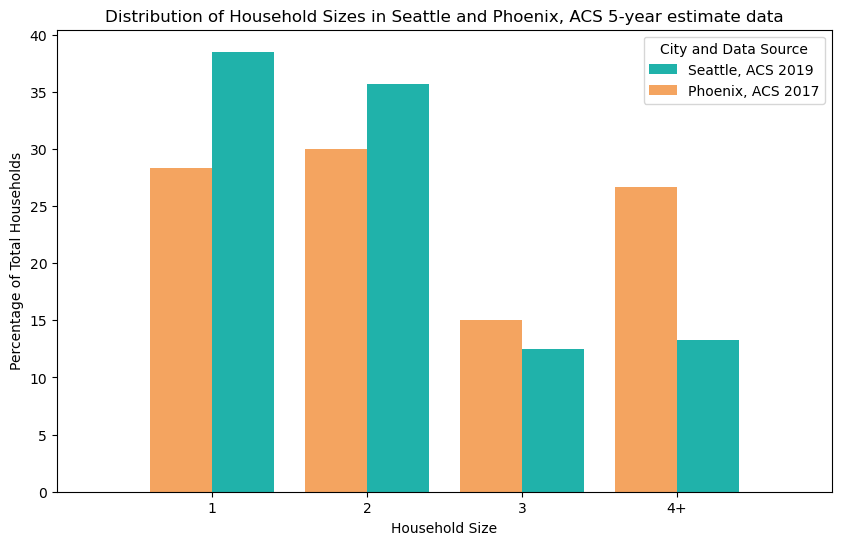

In [47]:
# plot distribution of household sizes in Seattle and Phoenix as a side-by-side bar plot
fig, ax = plt.subplots(figsize=(10, 6))
acs_sea_hh['HHSIZE_PCT'].plot(kind='bar', color='lightseagreen', width=0.4, position=0, ax=ax, label='Seattle')
acs_phx_hh['HHSIZE_PCT'].plot(kind='bar', color='sandybrown', width=0.4, position=1, ax=ax, label='Phoenix')

# set plot title and labels
plt.title('Distribution of Household Sizes in Seattle and Phoenix, ACS 5-year estimate data')
plt.xlabel('Household Size')
plt.ylabel('Percentage of Total Households')
plt.legend(['Seattle, ACS 2019', 'Phoenix, ACS 2017'], title='City and Data Source')
plt.xlim(-1, 4)

# set x ticks to list of household sizes
plt.xticks(range(4), acs_sea_hh['HHSIZE'], rotation=0)


In [48]:
# create dataframe for ACS household size data for Seattle
# data for Seattle MSA from ACS 2019 5-year estimates
acs_seamsa_hh = pd.DataFrame({'HHSIZE': ["1", "2", "3", "4+"],
                           'HHSIZE_PCT': [27.2, 34.5, 16.0, 22.3]})

# create dataframe for ACS household size data for Phoenix
# data for Phoenix MSA from ACS 2017 5-year estimates
acs_phxmsa_hh = pd.DataFrame({'HHSIZE': ["1", "2", "3", "4+"],
                           'HHSIZE_PCT': [26.8, 34.4, 14.4, 24.5]})

([<matplotlib.axis.XTick at 0x210039cee10>,
 [Text(0, 0, '1'), Text(1, 0, '2'), Text(2, 0, '3'), Text(3, 0, '4+')])

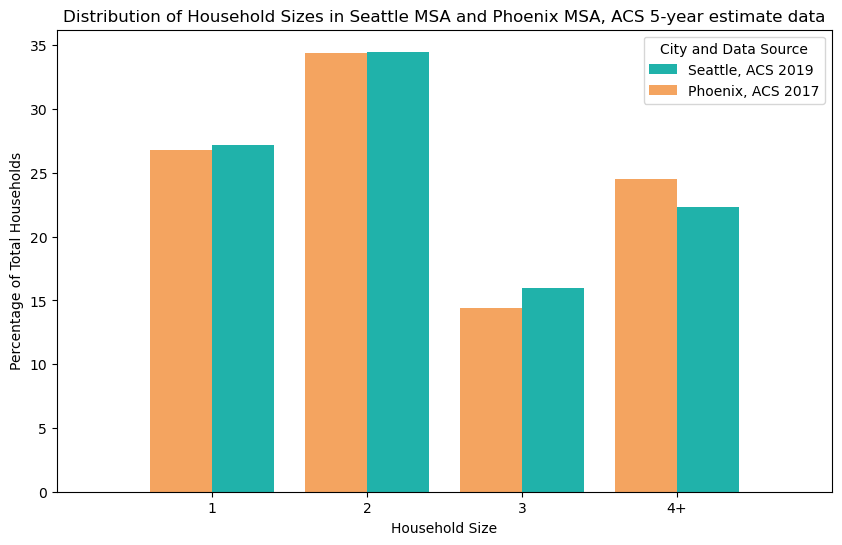

In [49]:
# plot distribution of household sizes in Seattle and Phoenix as a side-by-side bar plot
fig, ax = plt.subplots(figsize=(10, 6))
acs_seamsa_hh['HHSIZE_PCT'].plot(kind='bar', color='lightseagreen', width=0.4, position=0, ax=ax, label='Seattle')
acs_phxmsa_hh['HHSIZE_PCT'].plot(kind='bar', color='sandybrown', width=0.4, position=1, ax=ax, label='Phoenix')

# set plot title and labels
plt.title('Distribution of Household Sizes in Seattle MSA and Phoenix MSA, ACS 5-year estimate data')
plt.xlabel('Household Size')
plt.ylabel('Percentage of Total Households')
plt.legend(['Seattle, ACS 2019', 'Phoenix, ACS 2017'], title='City and Data Source')
plt.xlim(-1, 4)

# set x ticks to list of household sizes
plt.xticks(range(4), acs_sea_hh['HHSIZE'], rotation=0)


##### Compare MPS between Phoenix and Seattle, both sourced from NHTS 2017

In [52]:
# print Phoenix MPS data
mode_purpose_split_phx = mode_purpose_split
mode_purpose_split_phx

,overall_mode,overall_purpose,WTTRDFIN,mode_purpose_split
0,Drive,Commercial,3.084599e+08,21.79
1,Drive,Errand/Escort,1.411627e+08,9.97
2,Drive,Home,4.075136e+08,28.78
4,Drive,Social/Recreational,1.764007e+08,12.46
5,Drive,Work/School,1.664522e+08,11.76
6,NMT,Commercial,2.388016e+07,1.69
7,NMT,Errand/Escort,4.455284e+06,0.31
8,NMT,Home,6.965709e+07,4.92
10,NMT,Social/Recreational,4.326326e+07,3.06
11,NMT,Work/School,1.831808e+07,1.29


In [62]:
# drop rows with modes and purposes that are negative
# (-9: not ascertained, -8: I don't know, -7: prefer not to answer)
excluded_codes = [-9, -8, -7]
trips_sea = trips_sea[~(trips_sea['TRPTRANS'].isin(excluded_codes)) & ~(trips_sea['overall_purpose'].isin(excluded_codes))]

In [63]:
# calculate total number of weighted trips in City of Seattle
total_trips_sea = trips_sea['WTTRDFIN'].sum()
total_trips_sea

1010693893.2095149

In [65]:
# overall mode split
mode_split_sea = trips_sea[['overall_mode', 'WTTRDFIN']].groupby('overall_mode').sum()
# normalize
mode_split_sea['overall_mode'] = mode_split_sea['WTTRDFIN'] / mode_split_sea['WTTRDFIN'].sum()
mode_split_sea

,WTTRDFIN,overall_mode
overall_mode,,
Drive,4.875945e+08,0.482435
NMT,3.787878e+08,0.374780
Other,2.299259e+06,0.002275
Transit,1.420123e+08,0.140510


In [69]:
# overall purpose split
purpose_split_sea = trips_sea[['overall_purpose', 'WTTRDFIN']].groupby('overall_purpose').sum()
# normalize
purpose_split_sea['overall_purpose'] = purpose_split_sea['WTTRDFIN'] / purpose_split_sea['WTTRDFIN'].sum()
purpose_split_sea

,WTTRDFIN,overall_purpose
overall_purpose,,
Commercial,1.927288e+08,0.190690
Errand/Escort,7.920970e+07,0.078372
Home,3.144349e+08,0.311108
Other,3.577408e+07,0.035396
Social/Recreational,1.500100e+08,0.148423
Work/School,2.385364e+08,0.236012


In [72]:
# mode-purpose split
mode_purpose_split_sea = trips_sea[['overall_mode', 'overall_purpose', 'WTTRDFIN']].groupby(['overall_mode', 'overall_purpose']).sum()
# normalize
mode_purpose_split_sea['mode_purpose_split'] = np.round(mode_purpose_split_sea['WTTRDFIN'] / mode_purpose_split_sea['WTTRDFIN'].sum()*100, 2)
# mode_purpose_split_sea

In [71]:
# show mode_purpose_split for all overall_modes except other
mode_purpose_split_sea = mode_purpose_split_sea.reset_index()
mode_purpose_split_sea = mode_purpose_split_sea[(mode_purpose_split_sea['overall_mode'] != 'Other') & (mode_purpose_split_sea['overall_purpose'] != 'Other')]
mode_purpose_split_sea

,overall_mode,overall_purpose,WTTRDFIN,mode_purpose_split
0,Drive,Commercial,7.674987e+07,7.59
1,Drive,Errand/Escort,5.927881e+07,5.87
2,Drive,Home,1.610443e+08,15.93
4,Drive,Social/Recreational,7.991295e+07,7.91
5,Drive,Work/School,9.476432e+07,9.38
6,NMT,Commercial,1.108646e+08,10.97
7,NMT,Errand/Escort,1.564949e+07,1.55
8,NMT,Home,9.404943e+07,9.31
10,NMT,Social/Recreational,5.262362e+07,5.21
11,NMT,Work/School,8.918553e+07,8.82


##### Find additional drive trip passengers in Seattle from NHTS 2017

In [73]:
travel_mode = "Drive"
weighted_avg_pax_per_drive_trip_sea = np.sum(trips_sea[trips_sea["overall_mode"] == travel_mode]["TRPACCMP"] * trips_sea[trips_sea["overall_mode"] == travel_mode]["WTTRDFIN"]) / trips_sea[trips_sea["overall_mode"] == travel_mode]["WTTRDFIN"].sum()
weighted_avg_pax_per_drive_trip_sea

0.8449978992934646

In [74]:
# calculate mean number of passengers on drive trips, sorted by trip purpose
pax_per_drive_trip_sea = trips_sea[trips_sea["overall_mode"] == "Drive"].groupby("overall_purpose").apply(lambda x: np.sum(x["TRPACCMP"] * x["WTTRDFIN"]) / x["WTTRDFIN"].sum())
pax_per_drive_trip_sea

overall_purpose
Commercial             1.061436
Errand/Escort          0.998503
Home                   0.788913
Other                  0.530685
Social/Recreational    1.163062
Work/School            0.453327
dtype: float64